# Lesson 4: Vertical and horizontal scaling

This lesson is about making Python faster, in two dimensions:

<center>
<img src="../img/horizontal-and-vertical-scaling.svg" width="60%">
</center>

## Vertical scaling

Reminder: Python is slow.

<center>
<img src="../img/benchmark-games-2023.svg" width="90%">
</center>

We have already seen that NumPy (and Awkward Array) can circumvent Python's slowness by doing computationally intensive work in compiled code.

In [ ]:
import numpy as np
import awkward as ak

events = ak.from_parquet("../data/SMHiggsToZZTo4L.parquet")[:100000]

<br>

In [ ]:
%%timeit -r1 -n1

pz = [[muon.pt * np.sinh(muon.eta) for muon in event.muon] for event in events]

<br>

In [ ]:
%%timeit -r1 -n1

pz = events.muon.pt * np.sinh(events.muon.eta)

Array-oriented programming connects Python with compiled code, but it's not the only way to do that.

<img src="../img/history-of-bindings-2.svg" width="100%">

Although much faster than pure Python, array-oriented techniques are not as fast as imperative, compiled code.

In [ ]:
%%writefile quadratic_formula_c.c

#include <math.h>

void run(double* a, double* b, double* c, double* output) {
    for (int i = 0;  i < 1000000;  i++) {
        output[i] = (-b[i] + sqrt(b[i]*b[i] - 4*a[i]*c[i])) / (2*a[i]);
    }
}

In [1]:
!cc quadratic_formula_c.c -shared -lm -o quadratic_formula_c.so

clang: error: no such file or directory: 'quadratic_formula_c.c'


<br>

In [ ]:
import ctypes

quadratic_formula_c = ctypes.CDLL("./quadratic_formula_c.so")
quadratic_formula_c.run.argtypes = (ctypes.POINTER(ctypes.c_double),) * 4
quadratic_formula_c.run.restype = None

In [ ]:
a = np.random.uniform(5, 10, 1000000)
b = np.random.uniform(10, 20, 1000000)
c = np.random.uniform(-0.1, 0.1, 1000000)

<br>

In [ ]:
output = np.zeros(1000000, dtype=np.float64)
quadratic_formula_c.run(*[arg.ctypes.data_as(ctypes.POINTER(ctypes.c_double)) for arg in (a, b, c, output)])
output

<br>

In [ ]:
%%timeit

quadratic_formula_c.run(*[arg.ctypes.data_as(ctypes.POINTER(ctypes.c_double)) for arg in (a, b, c, output)])

<br>

In [ ]:
%%timeit

(-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

Why? NumPy allocates a new array for each intermediate step.

* Memory allocation is expensive (`malloc` has to search for unused memory).
* Accessing different memory is expensive (the CPU can't re-use its cache, and acessing RAM is much slower than most mathematical operations).

To calculate the first expression, NumPy takes the steps shown in the second:

<br>

In [ ]:
(-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

<br>

In [ ]:
tmp1 = np.negative(b)            # -b
tmp2 = np.square(b)              # b**2
tmp3 = np.multiply(4, a)         # 4*a
tmp4 = np.multiply(tmp3, c)      # tmp3*c
del tmp3
tmp5 = np.subtract(tmp2, tmp4)   # tmp2 - tmp4
del tmp2, tmp4
tmp6 = np.sqrt(tmp5)             # sqrt(tmp5)
del tmp5
tmp7 = np.add(tmp1, tmp6)        # tmp1 + tmp6
del tmp1, tmp6
tmp8 = np.multiply(2, a)         # 2*a
np.divide(tmp7, tmp8)            # tmp7 / tmp8     This is the result!

Best way to make C++ extensions for Python: pybind11

In [ ]:
%%writefile quadratic_formula_pybind11.cpp

#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
namespace py = pybind11;

void run(py::array_t<double, py::array::c_style | py::array::forcecast> a_numpy,
         py::array_t<double, py::array::c_style | py::array::forcecast> b_numpy,
         py::array_t<double, py::array::c_style | py::array::forcecast> c_numpy,
         py::array_t<double> output_numpy) {
    const double* a = a_numpy.data();
    const double* b = b_numpy.data();
    const double* c = c_numpy.data();
    double* output = output_numpy.mutable_data();
    for (int i = 0;  i < output_numpy.size();  i++) {
        output[i] = (-b[i] + sqrt(b[i]*b[i] - 4*a[i]*c[i])) / (2*a[i]);
    }
}

PYBIND11_MODULE(quadratic_formula_pybind11, m) {
    m.def("run", &run);
}

<br>

In [ ]:
import os
import sys
from pybind11 import get_include

inc = "-I " + get_include()
plat = "-undefined dynamic_lookup" if "darwin" in sys.platform else "-fPIC"
pyinc = !python3-config --cflags

<br>

In [ ]:
!c++ -std=c++11 quadratic_formula_pybind11.cpp -shared {inc} {pyinc.s} -o quadratic_formula_pybind11.so {plat}

In [ ]:
import quadratic_formula_pybind11

<br>

In [ ]:
output = np.zeros(1000000, dtype=np.float64)
quadratic_formula_pybind11.run(a, b, c, output)
output

<br>

In [ ]:
%%timeit

quadratic_formula_pybind11.run(a, b, c, output)

<br>

In [ ]:
%%timeit

(-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

Important! Put the loop over big data on the _compiled_ side of the boundary.

In [ ]:
%%writefile quadratic_formula_pybind11_noloop.cpp

#include <pybind11/pybind11.h>
namespace py = pybind11;

double run(double a, double b, double c) {
    return (-b + sqrt(b*b - 4*a*c)) / (2*a);
}
PYBIND11_MODULE(quadratic_formula_pybind11_noloop, m) {
    m.def("run", &run);
}

In [ ]:
!c++ -std=c++11 quadratic_formula_pybind11_noloop.cpp -shared {inc} {pyinc.s} -o quadratic_formula_pybind11_noloop.so {plat}

<br>

In [ ]:
import quadratic_formula_pybind11_noloop

<br>

In [ ]:
%%timeit

output = [quadratic_formula_pybind11_noloop.run(a_i, b_i, c_i) for a_i, b_i, c_i in zip(a, b, c)]

Leaving Python, writing C++ code, and then importing it* is fine for a long-term project, like a library that will be used many times, but it's inconvenient in the middle of a data analysis.

<br>

*If we change the C++, recompile, and do

```python
import quadratic_formula_pybind11
```

again, we will _not_ get the new version. We would still have the old version, with no error messages or warnings!

Numba is a Just In Time (JIT) compiler for _imperative_ Python.

In [ ]:
import numba as nb

<br>

In [ ]:
@nb.njit
def quadratic_formula_numba(a, b, c):
    output = np.empty(len(a), dtype=np.float64)
    for i, (a_i, b_i, c_i) in enumerate(zip(a, b, c)):
        output[i] = (-b_i + np.sqrt(b_i**2 - 4*a_i*c_i)) / (2*a_i)
    return output

quadratic_formula_numba(a, b, c)

<br>

In [ ]:
%%timeit

quadratic_formula_numba(a, b, c)

JAX is a JIT compiler for _array-oriented_ Python.

In [ ]:
import jax
jax.config.update("jax_platform_name", "cpu")

<br>

In [ ]:
@jax.jit
def quadratic_formula_jax(a, b, c):
    return (-b + jax.numpy.sqrt(b**2 - 4*a*c)) / (2*a)

quadratic_formula_jax(a, b, c)

<br>

In [ ]:
%%timeit

quadratic_formula_jax(a, b, c)

<br>

Note: it's hard to get JAX to use only one thread or use the CPU when a GPU is available, so use caution when interpreting performance results.

<center>
<img src="../img/slow-fast-imperative-vectorized.svg" width="80%">
</center>

Imperative versus vectorized (array-oriented) coding style is independent of slow versus fast.

<br><br>

Why would you want to pick one over the other?

* array-oriented style is simpler for certain types of problems, fits interactive data analysis cadence

* array-oriented style is more complicated or even impossible for some problems

<img src="../img/numerical-recipes.jpg" width="200px" align="right">

Suppose you need to calculate some special functions (and can't use SciPy).

<br>

Consider the log of the Gamma function,

$$\log\Gamma(z) \hspace{0.5 cm} \mbox{where} \hspace{0.5 cm} \Gamma(z) = \int_0^\infty t^{z - 1} e^{-t} \, dt$$

<br clear="right">

Page 214, converted from Pascal to Python:

In [ ]:
def log_of_gamma(x):
    tmp = x + 5.5
    tmp -= (x + 0.5) * np.log(tmp)
    series = 1.000000000190015
    for i, coefficient in enumerate([
        76.18009172947146, -86.50532032941677, 24.01409824083091,
        -1.231739572450155, 0.1208650973866179e-2, -0.5395239384953e-5,
    ]):
        series += coefficient / (x + i + 1)
    return -tmp + np.log(2.5066282746310005 * series / x)

Every line is a [closed-form](https://en.wikipedia.org/wiki/Closed-form_expression) expression (the loop over six coefficients could be "unrolled" into six lines), so this is very easy to vectorize.

In [ ]:
log_of_gamma(0.1), log_of_gamma(1), log_of_gamma(5), log_of_gamma(10)

<br>

In [ ]:
log_of_gamma(np.array([0.1, 1, 5, 10]))

<br>

In [ ]:
import matplotlib.pyplot as plt
import scipy.special

x = 10**np.linspace(-3, 1, 100)
plt.plot(x, log_of_gamma(x));
plt.scatter(x, scipy.special.loggamma(x), color="darkorange");

Now suppose that you want to compute the incomplete gamma $P(a, x)$.

$$P(a, x) = \frac{1}{\Gamma(a)} \int_0^x t^{a - 1} e^{-t} \, dt \hspace{0.5 cm} \mbox{where} \hspace{0.5 cm} a > 0$$

Page 219, converted from Pascal to Python:

In [ ]:
SMALL_NUMBER = 3e-7

def incomplete_gamma_P(a, x):
    gln = log_of_gamma(a)

    delta = summation = 1.0 / a

    for i in range(100):
        delta *= x / (a + i + 1)
        summation += delta
        if np.absolute(delta) < np.absolute(summation) * SMALL_NUMBER:
            return summation * np.exp(-x + a*np.log(x) - gln)

    raise RuntimeError("did not converge")

Although this can be computed for scalar inputs,

In [ ]:
plt.plot(x, [incomplete_gamma_P(0.5, x_i) for x_i in x]);
plt.plot(x, [incomplete_gamma_P(2, x_i) for x_i in x]);
plt.plot(x, [incomplete_gamma_P(10, x_i) for x_i in x]);
plt.scatter(x, scipy.special.gammainc(0.5, x));
plt.scatter(x, scipy.special.gammainc(2, x));
plt.scatter(x, scipy.special.gammainc(10, x));

It doesn't "just work" for arrays:

In [ ]:
incomplete_gamma_P(3.0, x)

<br><br>

Python can't decide whether to enter the body of the `if` statement or not because the expression may be true for some elements of the array and false for others.

**What should we do?**

Have all values continue to iterate, even if some have already converged?

In [ ]:
def incomplete_gamma_P_numpy_keep_going(a, x):
    gln = log_of_gamma(a)

    delta = summation = 1.0 / a

    for i in range(100):
        delta *= x / (a + i + 1)
        summation += delta

    return summation * np.exp(-x + a*np.log(x) - gln)

In [ ]:
plt.plot(x, incomplete_gamma_P_numpy_keep_going(0.5, x));
plt.plot(x, incomplete_gamma_P_numpy_keep_going(2.0, x));
plt.plot(x, incomplete_gamma_P_numpy_keep_going(10, x));

**What should we do?**

Keep track of which values have converged and don't compute those?

In [ ]:
def incomplete_gamma_P_numpy_tricky_bookkeeping(a, x):
    gln = log_of_gamma(a)

    delta = np.full(x.shape, 1.0 / a)
    summation = delta.copy()

    not_converged = np.ones(x.shape, np.bool_)

    for i in range(100):
        delta[not_converged] *= x[not_converged] / (a + i + 1)
        summation[not_converged] += delta[not_converged]
        not_converged &= np.absolute(delta) >= np.absolute(summation) * SMALL_NUMBER

    return summation * np.exp(-x + a*np.log(x) - gln)

In [ ]:
plt.plot(x, incomplete_gamma_P_numpy_tricky_bookkeeping(0.5, x));
plt.plot(x, incomplete_gamma_P_numpy_tricky_bookkeeping(2.0, x));
plt.plot(x, incomplete_gamma_P_numpy_tricky_bookkeeping(10, x));

**What should we do?**

Just write some imperative code?

In [ ]:
log_of_gamma_numba = nb.njit(log_of_gamma)

@nb.vectorize
def incomplete_gamma_P_numba(a, x):
    gln = log_of_gamma_numba(a)

    delta = summation = 1.0 / a

    for i in range(100):
        delta *= x / (a + i + 1)
        summation += delta
        if np.absolute(delta) < np.absolute(summation) * SMALL_NUMBER:
            return summation * np.exp(-x + a*np.log(x) - gln)

    raise RuntimeError("did not converge")

incomplete_gamma_P_numba(3.0, np.array([0.001, 1, 2, 10]))

In [ ]:
plt.plot(x, incomplete_gamma_P_numba(0.5, x));
plt.plot(x, incomplete_gamma_P_numba(2, x));
plt.plot(x, incomplete_gamma_P_numba(10, x));

So... which one's faster?

In [ ]:
%%timeit

incomplete_gamma_P_numpy_keep_going(3.0, x)

<br>

In [ ]:
%%timeit

incomplete_gamma_P_numpy_tricky_bookkeeping(3.0, x)

<br>

In [ ]:
%%timeit

incomplete_gamma_P_numba(3.0, x)

<br>

Tricky bookkeeping usually isn't helpful—it's usually better to let array-oriented code do unnecessary calculations than try to keep track of which calcuations are necessary. But imperative code lets you do exactly what you want.

The exercises are on vertical scaling, so do one now, before I talk about horizontal scaling.

## Horizontal scaling

<center>
<img src="../img/horizontal-and-vertical-scaling.svg" width="60%">
</center>

There are many ways to distribute a computation.

<br>

The traditional way is to use a batch queue, such as the LHC GRID. You can run Python scripts in a batch queue as easily as anything else.

<br>

This lecture will be about Dask, a popular way to distribute computations _within_ Python.

<center>
<img src="../img/logo-dask.svg" width="30%">
</center>

Dask is a library for describing a computation as a task graph.

In [ ]:
import dask

<br>

Eager Python code:

In [ ]:
def increment(i):
    return i + 1

def add(a, b):
    return a + b

a, b = 1, 12
c = increment(a)
d = increment(b)
output = add(c, d)

output

<br>

Lazy Python code:

In [ ]:
@dask.delayed
def increment(i):
    return i + 1

@dask.delayed
def add(a, b):
    return a + b

a, b = 1, 12
c = increment(a)
d = increment(b)
output = add(c, d)

output

In [ ]:
output.compute()

<br>

In [ ]:
output.visualize()

In [ ]:
import numpy as np
import dask.array as da

a = da.random.uniform(5, 10, 1000000)
b = da.random.uniform(10, 20, 1000000)
c = da.random.uniform(-0.1, 0.1, 1000000)

output = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
output

<br>

In [ ]:
output.visualize()

A task graph is a delayed computation—all the instructions that are needed to perform the computation at a later time.

<br>

This separates the problem of "what to compute?" from "when/where/on what resources to compute it?"

In [ ]:
import time

@dask.delayed
def start():
    print("start")
    time.sleep(0.5)
    return 1

@dask.delayed
def concurrent(initial, i):
    time.sleep(np.random.uniform(0, 1))
    print(f"concurrent {i}", end="")
    time.sleep(np.random.uniform(0, 0.05))
    print()
    return initial + i**2

@dask.delayed
def combine(partial_results):
    time.sleep(0.5)
    print("combine")
    return sum(partial_results)

initial = start()
output = combine([concurrent(initial, i) for i in range(10)])

In [ ]:
output.visualize()

Dask has three built-in schedulers (rarely used in production):

* `"synchronous"`: not parallel, intended for debugging
* `"threads"`: multiple threads in the same process, limited by the [Python GIL](https://realpython.com/python-gil/)
* `"processes"`: multiple Python processes; not affected by the GIL, but it has to start a bunch of processes

<br>

In [ ]:
with dask.config.set(scheduler="synchronous"):
    output.compute()

In a real system, we're more likely to use the Distributed library (or a third-party, such as Ray).

<img src="../img/distributed-overview.svg" width="100%">

<br><br><br><br><br>

_(Switch out of presentation view now.)_

<br><br><br><br><br>

Run in separate terminals:

```bash
dask-scheduler
```

and several of the following:

```bash
dask-worker --nthreads 1 127.0.0.1:8786
```

In [ ]:
import dask.distributed

client = dask.distributed.Client()
client

In [ ]:
output.compute()

<br><br><br><br><br>

## Dask collections

You can build general computations with `@dask.delayed`, but there are some common patterns that we'd want to build all the time.

For instance, splitting a calculation on NumPy arrays into embarrassingly parallel parts:

In [ ]:
import os

os.getcwd()

In [ ]:
import os
import h5py

dataset_hdf5 = h5py.File(os.getcwd() + "/../data/SMHiggsToZZTo4L.h5")

pt1 = da.from_array(dataset_hdf5["ee_mumu"]["e1"]["pt"], chunks=10000)
phi1 = da.from_array(dataset_hdf5["ee_mumu"]["e1"]["phi"], chunks=10000)
eta1 = da.from_array(dataset_hdf5["ee_mumu"]["e1"]["eta"], chunks=10000)
pt2 = da.from_array(dataset_hdf5["ee_mumu"]["e2"]["pt"], chunks=10000)
phi2 = da.from_array(dataset_hdf5["ee_mumu"]["e2"]["phi"], chunks=10000)
eta2 = da.from_array(dataset_hdf5["ee_mumu"]["e2"]["eta"], chunks=10000)

pt1

In [ ]:
mass = np.sqrt(2*pt1*pt2*(np.cosh(eta1 - eta2) - np.cos(phi1 - phi2)))
mass

In [ ]:
mass.visualize()

In [ ]:
from hist import Hist

Hist.new.Reg(120, 0, 120, name="dimuon mass").Double().fill(
    mass.compute()
).plot();

<br><br><br><br><br>

<img src="../img/dask-overview.svg" width="100%">

<br><br><br><br><br>

## The (new) dask-awkward collection

In [ ]:
import uproot
import awkward as ak

events = uproot.dask(os.getcwd() + "/../data/SMHiggsToZZTo4L.root")

# events = uproot.dask(
#     "https://pivarski-princeton.s3.amazonaws.com/cms-open-dimuons/Run2012B_DoubleMuParked.root",
#     step_size=1000,
# )

events

In [ ]:
selected = events[ak.num(events.Electron_pt) == 2]
selected

In [ ]:
pt1 = selected.Electron_pt[:, 0]
phi1 = selected.Electron_phi[:, 0]
eta1 = selected.Electron_eta[:, 0]
pt2 = selected.Electron_pt[:, 1]
phi2 = selected.Electron_phi[:, 1]
eta2 = selected.Electron_eta[:, 1]

pt1

In [ ]:
mass = np.sqrt(2*pt1*pt2*(np.cosh(eta1 - eta2) - np.cos(phi1 - phi2)))
mass

In [ ]:
mass.visualize()

In [ ]:
Hist.new.Reg(120, 0, 120, name="dimuon mass").Double().fill(
    mass.compute()
).plot();

### (Leave notebook for lecture on introduction to dask concepts)

## The rest of this notebook is meant for you to play around with!
## Try investigating `.dask` and other aspects of the taskgraphs below!

In [1]:
import dask
from dask.threaded import get
from dask.local import get_sync
from dask.optimization import cull, inline, inline_functions, fuse

def print_and_return(string):
    print(string)
    return string

def format_str(count, val, nwords):
    return (f'word list has {count} occurrences of '
            f'{val}, out of {nwords} words')

dsk = {'words': 'apple orange apple pear orange pear pear',
       'nwords': (len, (str.split, 'words')),
       'val1': 'orange',
       'val2': 'apple',
       'val3': 'pear',
       'count1': (str.count, 'words', 'val1'),
       'count2': (str.count, 'words', 'val2'),
       'count3': (str.count, 'words', 'val3'),
       'format1': (format_str, 'count1', 'val1', 'nwords'),
       'format2': (format_str, 'count2', 'val2', 'nwords'),
       'format3': (format_str, 'count3', 'val3', 'nwords'),
       'print1': (print_and_return, 'format1'),
       'print2': (print_and_return, 'format2'),
       'print3': (print_and_return, 'format3')}

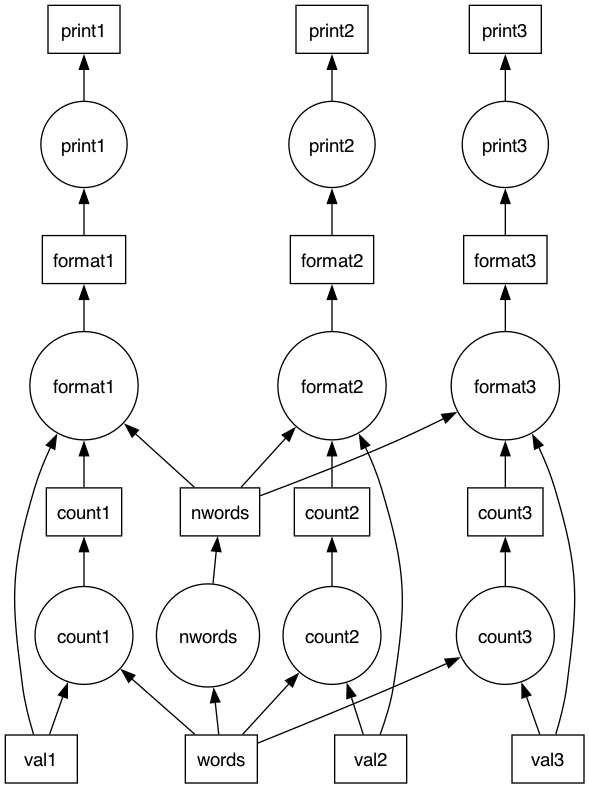

In [2]:
dask.base.visualize_dsk(dsk, verbose=True)

word list has 2 occurrences of orange, out of 7 words
word list has 2 occurrences of apple, out of 7 words


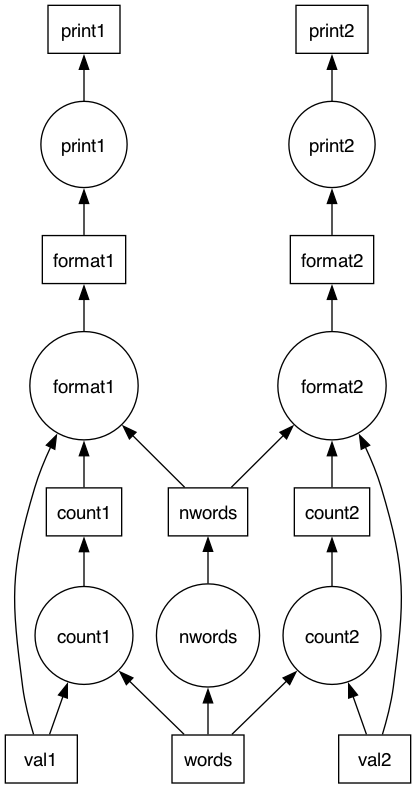

In [3]:
outputs = ['print1', 'print2']
dsk1, dependencies = cull(dsk, outputs)  # remove unnecessary tasks from the graph

results = get_sync(dsk1, outputs)

dask.base.visualize_dsk(dsk1, verbose=True)

word list has 2 occurrences of orange, out of 7 words
word list has 2 occurrences of apple, out of 7 words


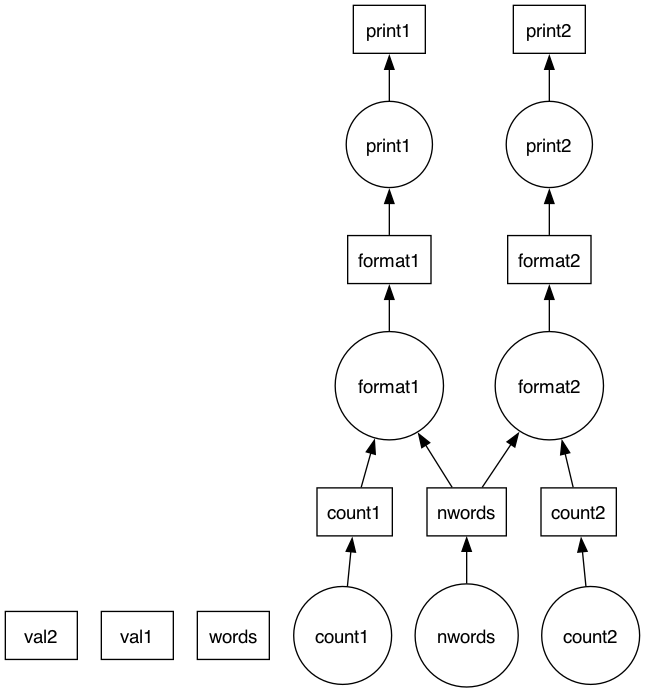

In [4]:
dsk2 = inline(dsk1, dependencies=dependencies)
results = get_sync(dsk2, outputs)

dask.base.visualize_dsk(dsk2, verbose=True)

word list has 2 occurrences of orange, out of 7 words
word list has 2 occurrences of apple, out of 7 words


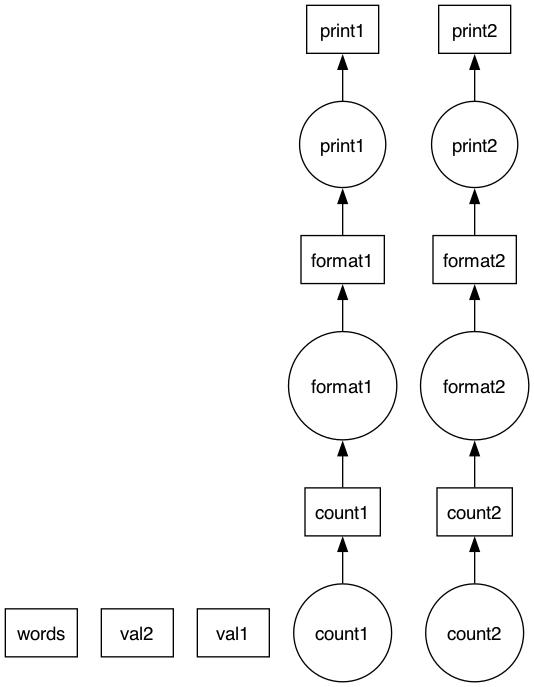

In [5]:
dsk3 = inline_functions(dsk2, outputs, [len, str.split], dependencies=dependencies)
results = get_sync(dsk3, outputs)

dask.base.visualize_dsk(dsk3, verbose=True)

word list has 2 occurrences of orange, out of 7 words
word list has 2 occurrences of apple, out of 7 words


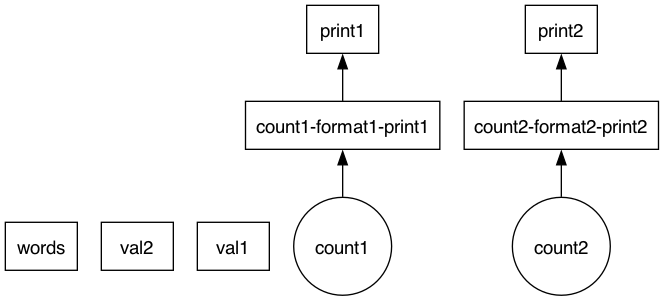

In [6]:
dsk4, dependencies = fuse(dsk3)
results = get_sync(dsk4, outputs)

dask.base.visualize_dsk(dsk4, verbose=True)

In [7]:
def optimize(dsk, keys):
    dsk1, deps = cull(dsk, keys)
    dsk2 = inline(dsk1, dependencies=deps)
    dsk3 = inline_functions(dsk2, keys, [len, str.split],
                            dependencies=deps)
    dsk4, deps = fuse(dsk3)
    return dsk4, deps

def optimize_and_get(dsk, keys):    
    dsk4, deps = optimize(dsk, keys)
    return get(dsk4, keys)

optimize_and_get(dsk, outputs)

word list has 2 occurrences of orange, out of 7 words
word list has 2 occurrences of apple, out of 7 words


('word list has 2 occurrences of orange, out of 7 words',
 'word list has 2 occurrences of apple, out of 7 words')

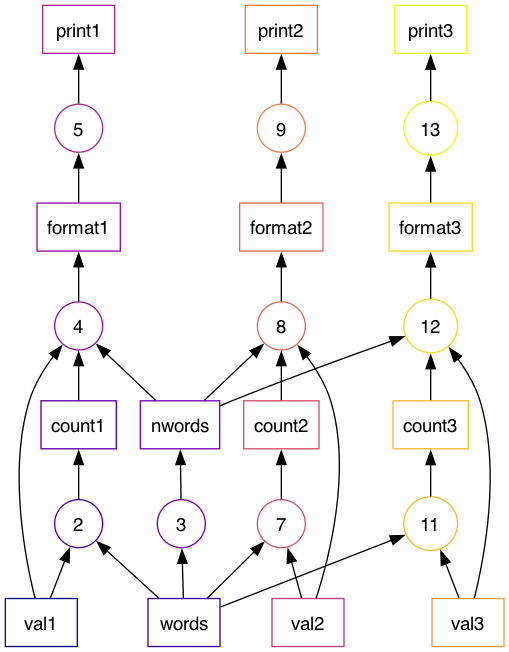

In [12]:
dask.base.visualize_dsk(dsk, verbose=True, color="order")

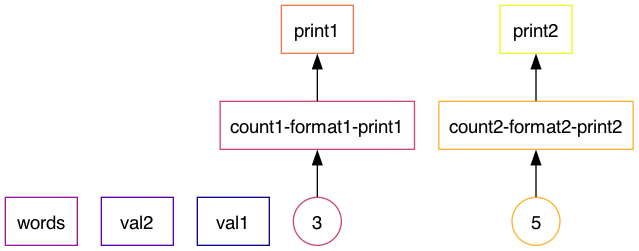

In [9]:
dsk5, _ = optimize(dsk, outputs)

dask.base.visualize_dsk(dsk5, verbose=True, color="order")

## what follows are more realistic analysis examples, using limited data so that we can focus on the graphs they produce!

In [13]:
import time

import awkward as ak
import hist
import matplotlib.pyplot as plt
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor

import dask
import dask_awkward as dak
import hist.dask as hda

# The opendata files are non-standard NanoAOD, so some optional data columns are missing
NanoAODSchema.warn_missing_crossrefs = False

# The warning emitted below indicates steps_per_file is for initial data exploration
# and test. When running at scale there are better ways to specify processing chunks
# of files.
events, report = NanoEventsFactory.from_root(
    {"https://github.com/CoffeaTeam/coffea/raw/master/tests/samples/nano_dy.root": "Events"},
    metadata={"dataset": "Test"},
    uproot_options={"allow_read_errors_with_report": True},
).events()

/Users/lgray/coffea-dev/coffea/src/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


# Query 1

Plot the <i>E</i><sub>T</sub><sup>miss</sup> of all events.

{'from-uproot-c50d576888021a2a2e69a3f46e0c94cb': frozenset({'MET_pt'})}

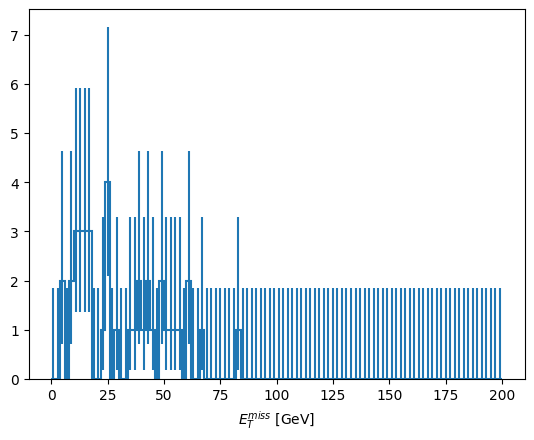

In [14]:
q1_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]")
    .Double()
    .fill(events.MET.pt)
)

dask.compute(q1_hist, report)[0].plot1d(flow="none")
dak.necessary_columns(q1_hist)

# Query 2
Plot the <i>p</i><sub>T</sub> of all jets.

In [ ]:
q2_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="ptj", label="Jet $p_{T}$ [GeV]")
    .Double()
    .fill(ak.flatten(events.Jet.pt))
)


q2_hist.compute().plot1d(flow="none")
dak.necessary_columns(q2_hist)

# Query 3
Plot the <i>p</i><sub>T</sub> of jets with |<i>η</i>| < 1.

In [ ]:
q3_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="ptj", label="Jet $p_{T}$ [GeV]")
    .Double()
    .fill(ak.flatten(events.Jet[abs(events.Jet.eta) < 1].pt))
)

q3_hist.compute().plot1d(flow="none")
dak.necessary_columns(q3_hist)

# Query 4
Plot the <i>E</i><sub>T</sub><sup>miss</sup> of events that have at least two jets with <i>p</i><sub>T</sub> > 40 GeV.

In [ ]:
has2jets = ak.sum(events.Jet.pt > 40, axis=1) >= 2
q4_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]")
    .Double()
    .fill(events[has2jets].MET.pt)
)

q4_hist.compute().plot1d(flow="none")
dak.necessary_columns(q4_hist)

# Query 5
Plot the <i>E</i><sub>T</sub><sup>miss</sup> of events that have an
opposite-charge muon pair with an invariant mass between 60 and 120 GeV.

In [ ]:
mupair = ak.combinations(events.Muon, 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
goodevent = ak.any(
    (pairmass > 60)
    & (pairmass < 120)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)
q5_hist = (
    hda.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]")
    .Double()
    .fill(events[goodevent].MET.pt)
)


q5_hist.compute().plot1d(flow="none")
dak.necessary_columns(q5_hist)

# Query 6
For events with at least three jets, plot the <i>p</i><sub>T</sub> of the trijet four-momentum that has the invariant mass closest to 172.5 GeV in each event and plot the maximum <i>b</i>-tagging discriminant value among the jets in this trijet.

In [ ]:
jets = ak.zip(
    {k: getattr(events.Jet, k) for k in ["x", "y", "z", "t", "btag"]},
    with_name="LorentzVector",
    behavior=events.Jet.behavior,
)
trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])
trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3
trijet = ak.flatten(
    trijet[ak.singletons(ak.argmin(abs(trijet.p4.mass - 172.5), axis=1))]
)
maxBtag = np.maximum(
    trijet.j1.btag,
    np.maximum(
        trijet.j2.btag,
        trijet.j3.btag,
    ),
)
q6_hists = {
    "trijetpt": hda.Hist.new.Reg(
        100, 0, 200, name="pt3j", label="Trijet $p_{T}$ [GeV]"
    )
    .Double()
    .fill(trijet.p4.pt),
    "maxbtag": hda.Hist.new.Reg(
        100, 0, 1, name="btag", label="Max jet b-tag score"
    )
    .Double()
    .fill(maxBtag),
}

out = dask.compute(q6_hists, report)[0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
out["trijetpt"].plot1d(ax=ax1, flow="none")
out["maxbtag"].plot1d(ax=ax2, flow="none")
dak.necessary_columns(q6_hists)

# Query 7
Plot the scalar sum in each event of the <i>p</i><sub>T</sub> of jets with <i>p</i><sub>T</sub> > 30 GeV that are not within 0.4 in Δ<i>R</i> of any light lepton with <i>p</i><sub>T</sub> > 10 GeV.

In [ ]:
cleanjets = events.Jet[
    ak.all(
        events.Jet.metric_table(events.Muon[events.Muon.pt > 10]) >= 0.4, axis=2
    )
    & ak.all(
        events.Jet.metric_table(events.Electron[events.Electron.pt > 10]) >= 0.4,
        axis=2,
    )
    & (events.Jet.pt > 30)
]
q7_hist = (
    hda.Hist.new.Reg(
        100, 0, 200, name="sumjetpt", label="Jet $\sum p_{T}$ [GeV]"
    )
    .Double()
    .fill(ak.sum(cleanjets.pt, axis=1))
)

q7_hist.compute().plot1d(flow="none")
dak.necessary_columns(q7_hist)

# Query 8
For events with at least three light leptons and a same-flavor opposite-charge light lepton pair, find such a pair that has the invariant mass closest to 91.2 GeV in each event and plot the transverse mass of the system consisting of the missing tranverse momentum and the highest-<i>p</i><sub>T</sub> light lepton not in this pair.

In [ ]:
events["Electron", "pdgId"] = -11 * events.Electron.charge
events["Muon", "pdgId"] = -13 * events.Muon.charge
events["leptons"] = ak.concatenate(
    [events.Electron, events.Muon],
    axis=1,
)
events = events[ak.num(events.leptons) >= 3]
pair = ak.argcombinations(events.leptons, 2, fields=["l1", "l2"])
pair = pair[(events.leptons[pair.l1].pdgId == -events.leptons[pair.l2].pdgId)]

pair = pair[
    ak.singletons(
        ak.argmin(
            abs(
                (events.leptons[pair.l1] + events.leptons[pair.l2]).mass
                - 91.2
            ),
            axis=1,
        )
    )
]

events = events[ak.num(pair) > 0]
pair = pair[ak.num(pair) > 0][:, 0]

l3 = ak.local_index(events.leptons)
l3 = l3[(l3 != pair.l1) & (l3 != pair.l2)]
l3 = l3[ak.argmax(events.leptons[l3].pt, axis=1, keepdims=True)]
l3 = events.leptons[l3][:, 0]

mt = np.sqrt(2 * l3.pt * events.MET.pt * (1 - np.cos(events.MET.delta_phi(l3))))
q8_hist = (
    hda.Hist.new.Reg(
        100, 0, 200, name="mt", label="$\ell$-MET transverse mass [GeV]"
    )
    .Double()
    .fill(mt)
)

q8_hist.compute().plot1d(flow="none")
dak.necessary_columns(q8_hist)